In [27]:
import numpy as np
import pandas as pd
import requests
import json

url = "http://api.apixu.com/v1/history.json?key=f87b86729047441786b83603190105&q=Gursuf, Krym, Ukraine&dt=2019-05-22&hour=12"
JSONContent = requests.get(url).json()
content = json.dumps(JSONContent, indent = 4, sort_keys=True)
print(JSONContent['forecast']['forecastday'][0]['hour'][0]['cloud'])

54


In [28]:
cities = ['Skopje', 'London', 'Ljubljana', 'Paris', 'Rome', 'Berlin', 'Madrid', 'Barcelona', 'Stockholm', 'Sofia', 'Belgrade', 'Graz']
cities_list = []

for city in cities:
    for i in range(16, 22):
        JSONContent = requests.get("http://api.apixu.com/v1/history.json?key=f87b86729047441786b83603190105&dt=2019-05-" + str(i) + "&q=" + city).json()
        for j in range(0, 24):
            cities_list.append([city, i, j + 1,
                                JSONContent['forecast']['forecastday'][0]['hour'][j]['temp_c'], 
                              JSONContent['forecast']['forecastday'][0]['hour'][j]['pressure_mb'],
                              JSONContent['forecast']['forecastday'][0]['hour'][j]['humidity'], 
                              JSONContent['forecast']['forecastday'][0]['hour'][j]['cloud']])

dataset = pd.DataFrame(cities_list)

In [29]:
dataset.columns = ["City", "Day in May 2019", "Hour", "Temperature", "Pressure", "Humidity", "Cloud cover"]
dataset.tail()

City  Day in May 2019  Hour  Temperature  Pressure  Humidity  \
1723  Graz               21    20         15.6    1010.0        72   
1724  Graz               21    21         14.7    1011.0        76   
1725  Graz               21    22         13.7    1011.0        80   
1726  Graz               21    23         13.2    1012.0        82   
1727  Graz               21    24         12.8    1012.0        84   

      Cloud cover  
1723           71  
1724           76  
1725           82  
1726           81  
1727           81

In [30]:
tmp = dataset[['City', 'Temperature', 'Cloud cover']].head(10)
tmp

City  Temperature  Cloud cover
0  Skopje          9.8           76
1  Skopje          9.6           77
2  Skopje          9.4           78
3  Skopje          9.2           79
4  Skopje          9.8           84
5  Skopje         10.4           89
6  Skopje         11.0           93
7  Skopje         11.7           90
8  Skopje         12.4           86
9  Skopje         13.1           82

In [31]:
hours_prior = 1
feature = "Cloud cover"

rows = tmp.shape[0]
nth_prior_measurements = [None]*hours_prior
for i in range(hours_prior, rows):
    #cleaning different cities
    if tmp["City"][i] == tmp["City"][i-hours_prior]:
        nth_prior_measurements += [tmp[feature][i-hours_prior]]
    else:
        nth_prior_measurments += None

# make a new column name of feature_hours and add to DataFrame
col_name = "{}_{}".format(feature, hours_prior)  
tmp[col_name] = nth_prior_measurements

tmp

City  Temperature  Cloud cover  Cloud cover_1
0  Skopje          9.8           76            NaN
1  Skopje          9.6           77           76.0
2  Skopje          9.4           78           77.0
3  Skopje          9.2           79           78.0
4  Skopje          9.8           84           79.0
5  Skopje         10.4           89           84.0
6  Skopje         11.0           93           89.0
7  Skopje         11.7           90           93.0
8  Skopje         12.4           86           90.0
9  Skopje         13.1           82           86.0

In [32]:
def derive_prior_hours(dataset, feature, hours_prior):
    rows = dataset.shape[0]
    global nth_prior_measurements
    nth_prior_measurements = [None]*hours_prior
    for i in range(hours_prior, rows):
        #cleaning different cities
        if dataset["City"][i] == dataset["City"][i-hours_prior]:
            nth_prior_measurements += [dataset[feature][i-hours_prior]]
        else:
            nth_prior_measurements += [None]

    # make a new column name of feature_hours and add to DataFrame
    col_name = "{}_{}".format(feature, hours_prior)  
    dataset[col_name] = nth_prior_measurements

In [33]:
for feature in ['Temperature', 'Pressure', 'Humidity', 'Cloud cover']:  
        for hours_prior in range(1, 8):
            derive_prior_hours(dataset, feature, hours_prior)

In [34]:
dataset = dataset.dropna()

In [35]:
dataset.head()

City  Day in May 2019  Hour  Temperature  Pressure  Humidity  \
7   Skopje               16     8         11.7    1011.0        79   
8   Skopje               16     9         12.4    1011.0        78   
9   Skopje               16    10         13.1    1011.0        76   
10  Skopje               16    11         14.0    1010.0        72   
11  Skopje               16    12         14.9    1010.0        68   

    Cloud cover  Temperature_1  Temperature_2  Temperature_3  ...  Humidity_5  \
7            90           11.0           10.4            9.8  ...        84.0   
8            86           11.7           11.0           10.4  ...        87.0   
9            82           12.4           11.7           11.0  ...        85.0   
10           82           13.1           12.4           11.7  ...        83.0   
11           83           14.0           13.1           12.4  ...        81.0   

    Humidity_6  Humidity_7  Cloud cover_1  Cloud cover_2  Cloud cover_3  \
7         82.0        80.0           93.0           89.0           84.0   
8         84.0        82.0           90.0           93.0           89.0   
9         87.0        84.0           86.0           90.0           93.0   
10        85.0        87.0           82.0           86.0           90.0   
11        83.0        85.0           82.0           82.0           86.0   

    Cloud cover_4  Cloud cover_5  Cloud cover_6  Cloud cover_7  
7            79.0           78.0           77.0           76.0  
8            84.0           79.0           78.0           77.0  
9            89.0           84.0           79.0           78.0  
10           93.0           89.0           84.0           79.0  
11           90.0           93.0           89.0           84.0  

[5 rows x 35 columns]

In [ ]:
#Linear regression model

In [67]:
dataset.corr()[['Cloud cover']].sort_values("Cloud cover")

Cloud cover
Pressure           -0.527218
Pressure_1         -0.525353
Pressure_2         -0.520237
Pressure_3         -0.511414
Pressure_4         -0.499313
Pressure_5         -0.484766
Pressure_6         -0.467354
Pressure_7         -0.448437
Temperature        -0.195695
Temperature_1      -0.186700
Temperature_2      -0.180050
Temperature_3      -0.175585
Temperature_4      -0.172803
Temperature_5      -0.171524
Temperature_6      -0.170650
Temperature_7      -0.169824
Day in May 2019    -0.110019
Hour               -0.001931
Humidity_7          0.191673
Humidity_6          0.204643
Humidity_5          0.217160
Humidity_4          0.228930
Humidity_3          0.241637
Humidity_2          0.255069
Humidity_1          0.269379
Humidity            0.284250
Cloud cover_7       0.589275
Cloud cover_6       0.654004
Cloud cover_5       0.723693
Cloud cover_4       0.795752
Cloud cover_3       0.866599
Cloud cover_2       0.931931
Cloud cover_1       0.980094
Cloud cover         1.000000

In [36]:
#Picking columns correlated more than 0.5 or less than -0.5
predictors = ['Cloud cover_1', 'Cloud cover_2', 'Cloud cover_3', 'Cloud cover_4', 'Cloud cover_5', 'Cloud cover_6','Cloud cover_7', 'Pressure', 'Pressure_1', 'Pressure_2', 'Pressure_3', 'Pressure_4']

dataset2 = dataset[['Cloud cover'] + predictors]

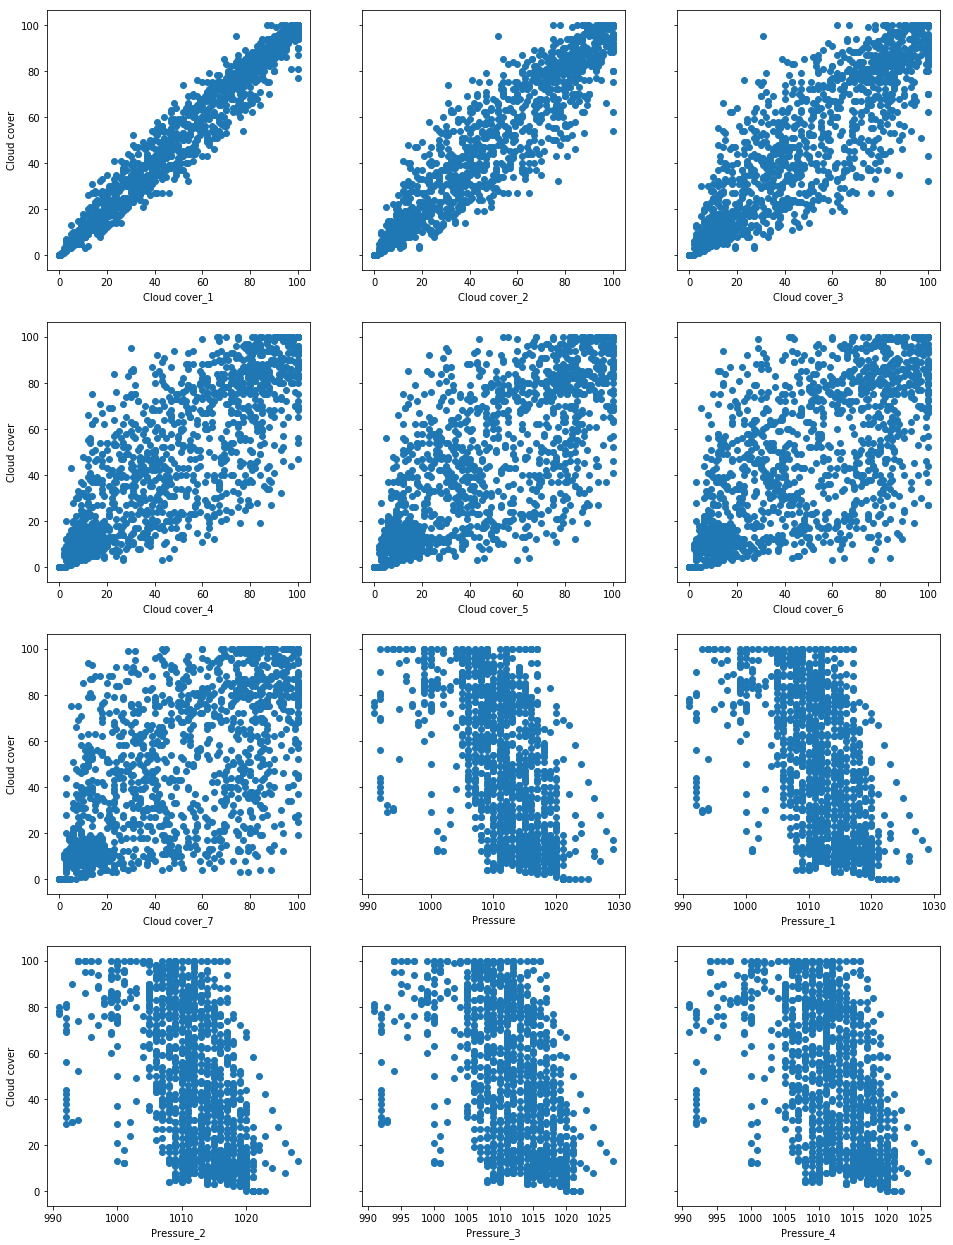

In [72]:
#Visualisation

import matplotlib  
import matplotlib.pyplot as plt  
import numpy as np  

%matplotlib inline

# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [16, 22]

fig, axes = plt.subplots(nrows=4, ncols=3, sharey=True)

arr = np.array(predictors).reshape(4, 3)

for row, col_arr in enumerate(arr):  
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(dataset2[feature], dataset2['Cloud cover'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='Cloud cover')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X = dataset[predictors]  
y = dataset['Cloud cover']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12) 

In [39]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

prediction = regressor.predict(X_test)

print(regressor.score(X_test, y_test))

0.9853821297864541


In [19]:
import datetime as dt

hour = dt.datetime.now().hour
day = dt.datetime.now().day
new = ['Skopje', day, hour]

url = "http://api.apixu.com/v1/history.json?key=f87b86729047441786b83603190105&q=Gursuf, Krym, Ukraine&dt=2019-05-22&hour="+str(hour)
Temperature = JSONContent['forecast']['forecastday'][0]['hour'][0]['temp_c']
Pressure = JSONContent['forecast']['forecastday'][0]['hour'][0]['pressure_mb']
Humidity = JSONContent['forecast']['forecastday'][0]['hour'][0]['humidity']
Cloud_cover = JSONContent['forecast']['forecastday'][0]['hour'][0]['cloud']

new.append(Temperature)
new.append(Pressure)
new.append(Humidity)
new.append(Cloud_cover)

for i in range(hour - 8, hour - 1):
    url = "http://api.apixu.com/v1/history.json?key=f87b86729047441786b83603190105&q=Gursuf, Krym, Ukraine&dt=2019-05-22&hour="+str(i)
    JSONContent = requests.get(url).json()
    Temperature = JSONContent['forecast']['forecastday'][0]['hour'][0]['temp_c']
    new.append(Temperature)

for i in range(hour - 8, hour - 1):
    url = "http://api.apixu.com/v1/history.json?key=f87b86729047441786b83603190105&q=Gursuf, Krym, Ukraine&dt=2019-05-22&hour="+str(i)
    JSONContent = requests.get(url).json()
    Pressure = JSONContent['forecast']['forecastday'][0]['hour'][0]['pressure_mb']
    new.append(Pressure)
    
for i in range(hour - 8, hour - 1):
    url = "http://api.apixu.com/v1/history.json?key=f87b86729047441786b83603190105&q=Gursuf, Krym, Ukraine&dt=2019-05-22&hour="+str(i)
    JSONContent = requests.get(url).json()
    Humidity = JSONContent['forecast']['forecastday'][0]['hour'][0]['humidity']
    new.append(Humidity)
    
for i in range(hour - 8, hour - 1):
    url = "http://api.apixu.com/v1/history.json?key=f87b86729047441786b83603190105&q=Gursuf, Krym, Ukraine&dt=2019-05-22&hour="+str(i)
    JSONContent = requests.get(url).json()
    Cloud_cover = JSONContent['forecast']['forecastday'][0]['hour'][0]['cloud']
    new.append(Cloud_cover)
print(new)


['Skopje', 22, 16, 17.8, 1014.0, 76, 27, 15.9, 16.8, 17.3, 17.7, 18.2, 18.1, 17.9, 1014.0, 1014.0, 1014.0, 1014.0, 1014.0, 1014.0, 1014.0, 87, 87, 84, 81, 78, 77, 77, 64, 66, 62, 58, 54, 45, 36]


In [52]:
new_data = pd.DataFrame([new], columns = list(dataset.columns.values))

new_data.head()

City  Day in May 2019  Hour  Temperature  Pressure  Humidity  \
0  Skopje               22    16         17.8    1014.0        76   

   Cloud cover  Temperature_1  Temperature_2  Temperature_3  ...  Humidity_5  \
0           27           15.9           16.8           17.3  ...          78   

   Humidity_6  Humidity_7  Cloud cover_1  Cloud cover_2  Cloud cover_3  \
0          77          77             64             66             62   

   Cloud cover_4  Cloud cover_5  Cloud cover_6  Cloud cover_7  
0             58             54             45             36  

[1 rows x 35 columns]

In [54]:
dataset.to_csv('8_hours_prior_data')

In [58]:
#Prediction of cloud cover
X = new_data[predictors]
print(regressor.predict(X)[0].round())

60.0


In [18]:
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LinearRegression

dataset = pd.read_csv('8_hours_prior_data')
predictors = ['Cloud cover_1', 'Cloud cover_2', 'Cloud cover_3', 'Cloud cover_4', 'Cloud cover_5', 'Cloud cover_6','Cloud cover_7', 'Pressure', 'Pressure_1', 'Pressure_2', 'Pressure_3', 'Pressure_4']
X = dataset[predictors]  
y = dataset['Cloud cover']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

regressor = LinearRegression()
regressor.fit(X_train, y_train)
            
filename = 'finalized_model.sav'
pickle.dump(regressor, open(filename, 'wb'))